# Emotional TTS - C1 Report

Similar to progress report [here](https://github.com/NVIDIA/NeMo/blob/tts_aagermanfastpitch/generate_progress.ipynb) and [here](https://github.com/NVIDIA/NeMo/blob/tts_aagermanfastpitch/progress_phonemes.ipynb).

Experiment: C1 - Train Emotional TTS just like German TTS model recipe for FastPitch and HiFi-GAN as mentioned [here](https://github.com/NVIDIA/NeMo/blob/r1.10.0/tutorials/tts/Fastpitch_Training_GermanTTS.ipynb).
- E1 refers to spectrogram generator
- E2 refers to vocoder

[wandb dashboard](https://wandb.ai/aroraakshit/EmotionalTTS?workspace=user-aroraakshit)

C1 code branch: [tts_aaemotionaltts](https://github.com/NVIDIA/NeMo/tree/tts_aaemotionaltts)

Models trained:

* `c1e1-FastPitch-pretrain`: FastPitch trained on german neutral dataset (openslr/95) from scratch. Similar to FastPitch German ckpt (`nvidia/nemo/tts_de_fastpitchhifigan:1.10.0`) but with extra n_emotions set to 9 (so it can accept new emotions while finetuning).
* `c1e2-HifiGAN-finetune-pretrain`: HiFi-GAN english (`nvidia/nemo/tts_en_fastpitch:1.8.1`) finetuned on predicted mels from `c1e1-FastPitch-pretrain`
* `c1e1-FastPitch-finetune`: Fine-tuned `c1e1-FastPitch-pretrain` on German emotional (openslr/110) dataset
* `c1e2-HifiGAN-finetune2-pretrain-emotional`: finetuning `c1e2-HifiGAN-finetune-pretrain` with `c1e1-FastPitch-finetune` + emotional TTS predicted mels 
* `c1e2-HifiGAN-pretrain-emotional`: Launch finetunining hifigan (pretrained on german from ngc `nvidia/nemo/tts_de_fastpitchhifigan:1.10.0`) on `c1e1-FastPitch-pretrain` + emotional tts dataset pred mels
* `c1e2-HifiGAN-finetune-emotional`: Launch finetuning hifigan (pretrained on german from ngc `nvidia/nemo/tts_de_fastpitchhifigan:1.10.0`) on `c1e1-FastPitch-finetune` + emotional tts dataset pred mels

nvstaging/nemo/tts_de_fastpitchhifigan:1.10.0

Old models referred:
* `R6priorckpts`: fine-tuned HiFiGAN english on German neutral dataset (aka `nvidia/nemo/tts_de_fastpitchhifigan:1.10.0`)

Comparisons listed:

1. `c1e1-FastPitch-pretrain` + `c1e2-HifiGAN-finetune-pretrain` (basically same as previously published, but with the emotional embedding layer, unused)
2. NO USE - `c1e1-FastPitch-pretrain` + `R6priorckpts` - what if we use the old german hifigan but new fastpitch (with the emotional embedding layer)? - just curious
3. NO USE - `c1e1-FastPitch-finetune` + `R6priorckpts` - what if we use the old german hifigan but new fastpitch finetuned? - just curious.
4. NO USE - `c1e1-FastPitch-finetune` + `c1e2-HifiGAN-finetune-pretrain`
5. SHOULD WORK - `c1e1-FastPitch-finetune` + `c1e2-HifiGAN-finetune2-pretrain-emotional`
6. NO USE - `c1e1-FastPitch-finetune` + `c1e2-HifiGAN-pretrain-emotional`
7. IDEAL - `c1e1-FastPitch-finetune` + `c1e2-HifiGAN-finetune-emotional`

In [1]:
from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.models import HifiGanModel
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import torch
import numpy as np
import os

[NeMo W 2022-08-24 16:22:55 nemo_logging:349] /opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
      warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)
    
[NeMo W 2022-08-24 16:22:56 experimental:27] Module <class 'nemo.collections.tts.torch.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [19]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

seed=100
# test = "Man darf sich nicht von anderen entmutigen lassen."
# test_id = "2edfc39c95ef247c6e39c929d122f4cc"
data_path="/DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/wavs/"

# 5 test samples

# test = "Dieser Pilz ist zwar nicht giftig, aber ungenie\u00dfbar."
# test_id = "b1e9265fcc34a4d3691eb2c6921198a2"

# test = "Denn wir wollen nat\u00fcrlich nicht, dass durch die Einf\u00fchrung von Mindestlohn die Menschen, die heute eine Arbeit haben, vielleicht dann arbeitslos werden."
# test_id = "625fee42255c5524910b1461ea67472f"

# test = "Der Kostenvoranschlag schaut wie folgt aus."
# test_id = "a7deaaa56acc87bc0af428333f99280e"

# test = "Wie ist das Rezept f\u00fcr ein Bierbowle"
# test_id = "8cb57204a72a08b7cd51f7d1976f0d8a"

# test_id = "757f8af609039c1b842fd220486b6ebc"
# test = "Ja, selbstverst\u00e4ndlich! Das ist bei uns Standard."

# 5 val samples

# test = "Weshalb ist die Veredelung der Pflanzen \u00fcberhaupt notwendig?"
# test_id = "7c81f276eacc87c4e5482c2334a08171"

# test = "Hast du noch einen letzten Wunsch?"
# test_id = "fde9c0a1099210c03ac5de300fd478d6"

# test = "Der Veranstalter des Konzerts sieht dies naturgem\u00e4\u00df etwas anders."
# test_id = "29b18466bbbbbbac760c36d87ba2734c"

# test = "Kurzz\u00fcge halten hier."
# test_id = "21cb9b6bca12b97f8ba26e3a1829d18b"

test = "Diese Musiksammlung soll die Vielfalt des Lebens widerspiegeln."
test_id = "877d9f668a877713b48735f282af62ca"

In [3]:
# data points for emotional TTS

data_path_emotions = "/DataEmotionalTTS/thorsten-emotional_v02/"
emo_map = {8:"neutral", 1:"amused", 2:"angry", 3:"disgusted", 4:"drunk", 5:"sleepy", 6:"surprised", 7:"whisper"}

# train sample
test_emotion = "Aber ich glaube, es ist auch eine Aufforderung an alle, wobei ich diese pauschale Verurteilung v\u00f6llig falsch finde."
test_id_emotion = "645607a5efbc0dbc96f62a9000feb393"

# test_emotion = "Und dabei bringt es auch nichts, sich den Mund fusselig zu reden."
# test_id_emotion = "00f0a2d86d55a19e08c1676a16307cbd"

# test_emotion = "Nein, das war kein Kompliment."
# test_id_emotion = "3610f6924ae384c8fbcfd8b8c14c7197"

# test sample

# test_emotion = "Dann ist er bei Adriane genau an der richtigen Adresse"
# test_id_emotion = "a9f0d2b712d71b40495396372a408762"

# val sample

# test_emotion = "Des Herstellers Produktpalette ist mittlerweile riesig"
# test_id_emotion = "bdf199ae7985ae4ced4edbe9d86220ba"


In [20]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test, emotion=8):
    with torch.no_grad():
#         torch.manual_seed(seed)
#         torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, emotion=emotion)
        print(spectrogram.size()) # debug
    #     audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram, sigma=0.8, denoise=True)
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

## 1. `c1e1-FastPitch-pretrain` + `c1e2-HifiGAN-finetune-pretrain` (basically same as previously published, but with the emotional embedding layer, unused)

In [ ]:
# list available c1e1-FastPitch-pretrain and c1e2-HifiGAN-finetune-pretrain models
!ls /ngc_results_backup/emotionaltts/3179869-07282022_testc1e1_ngc/c1e1-FastPitch-pretrain/2022-07-29_04-44-18/checkpoints/
!ls /ngc_results_backup/emotionaltts/3251622-08162022_testc1e1_c1e2_ngc/c1e1-HifiGAN-finetune-pretrain/2022-08-17_04-16-29/checkpoints/

In [ ]:
cmp1_fp = "/ngc_results_backup/emotionaltts/3179869-07282022_testc1e1_ngc/c1e1-FastPitch-pretrain/2022-07-29_04-44-18/checkpoints/c1e1-FastPitch-pretrain.nemo"
cmp1_hfg = "/ngc_results_backup/emotionaltts/3251622-08162022_testc1e1_c1e2_ngc/c1e1-HifiGAN-finetune-pretrain/2022-08-17_04-16-29/checkpoints/c1e1-HifiGAN-finetune-pretrain--val_loss=0.3257-epoch=549.ckpt"

In [ ]:
cmp1_fp_model = FastPitchModel.restore_from(restore_path=cmp1_fp).eval().cuda()
cmp1_hfg_model = HifiGanModel.load_from_checkpoint(checkpoint_path=cmp1_hfg).eval().cuda()

In [ ]:
print("comparison 1")
audio, spectrogram = evaluate_spec_fastpitch_ckpt(cmp1_fp_model, cmp1_hfg_model, test, emotion=8)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

In [ ]:
# Observation: works right!

## 2. NO USE - `c1e1-FastPitch-pretrain` + `R6priorckpts` - what if we use the old german hifigan but new fastpitch (with the emotional embedding layer)? - just curious

In [ ]:
# list available c1e1-FastPitch-pretrain and R6priorckpts models
!ls /ngc_results_backup/emotionaltts/3179869-07282022_testc1e1_ngc/c1e1-FastPitch-pretrain/2022-07-29_04-44-18/checkpoints/
# !ls /ngc_results_backup/germantts/2937895_05202022_testr61_ngc/HifiGan21/2022-05-20_22-49-12/checkpoints/
!ls /DataEmotionalTTS/tts_de_fastpitchhifigan_v1.10.0/tts_de_hifigan.nemo

In [ ]:
cmp2_fp = "/ngc_results_backup/emotionaltts/3179869-07282022_testc1e1_ngc/c1e1-FastPitch-pretrain/2022-07-29_04-44-18/checkpoints/c1e1-FastPitch-pretrain.nemo"
cmp2_hfg = "/DataEmotionalTTS/tts_de_fastpitchhifigan_v1.10.0/tts_de_hifigan.nemo"

In [ ]:
cmp2_fp_model = FastPitchModel.restore_from(restore_path=cmp2_fp).eval().cuda()
cmp2_hfg_model = HifiGanModel.restore_from(restore_path=cmp2_hfg).eval().cuda()

In [ ]:
print("comparison 2")
audio, spectrogram = evaluate_spec_fastpitch_ckpt(cmp2_fp_model, cmp2_hfg_model, test, emotion=8)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

In [ ]:
# Observation: slightly more clearer than comparison 1

## 3. NO USE - `c1e1-FastPitch-finetune` + `R6priorckpts` - what if we use the old german hifigan but new fastpitch finetuned? - just curious.

In [ ]:
# list available c1e1-FastPitch-finetune and R6priorckpts models
!ls /ngc_results_backup/emotionaltts/local-07282022_testc1e1_ngc_finetune/c1e1-FastPitch-finetune/2022-08-01_22-12-34/checkpoints/
!ls /ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/
# !ls /ngc_results_backup/germantts/2937895_05202022_testr61_ngc/HifiGan21/2022-05-20_22-49-12/checkpoints/
!ls /DataEmotionalTTS/tts_de_fastpitchhifigan_v1.10.0/tts_de_hifigan.nemo

In [ ]:
cmp3_fp = "/ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo"
cmp3_hfg = "/DataEmotionalTTS/tts_de_fastpitchhifigan_v1.10.0/tts_de_hifigan.nemo"

In [ ]:
cmp3_fp_model = FastPitchModel.restore_from(restore_path=cmp3_fp).eval().cuda()
cmp3_hfg_model = HifiGanModel.restore_from(restore_path=cmp3_hfg).eval().cuda()

In [ ]:
print("comparison 3")

audio, spectrogram = evaluate_spec_fastpitch_ckpt(cmp3_fp_model, cmp3_hfg_model, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

In [ ]:
print("comparison 3 with emotion")

for emotion in range(1,10):
    audio, spectrogram = evaluate_spec_fastpitch_ckpt(cmp3_fp_model, cmp3_hfg_model, test_emotion, emotion=emotion)

    # visualize the spectrogram
    if spectrogram is not None:
        imshow(spectrogram, origin="lower")
        plt.show()

    # audio
    print("original audio")
    ipd.display(ipd.Audio(data_path_emotions+emo_map[emotion]+"/"+test_id_emotion+'.wav', rate=22050))
    print("predicted audio for emotion "+str(emotion)+":"+emo_map[emotion])
    ipd.display(ipd.Audio(audio, rate=22050))

## 4. NO USE - `c1e1-FastPitch-finetune` + `c1e2-HifiGAN-finetune-pretrain`

In [1]:
# list available c1e1-FastPitch-finetune and c1e2-HifiGAN-finetune-pretrain models
!ls /ngc_results_backup/emotionaltts/local-07282022_testc1e1_ngc_finetune/c1e1-FastPitch-finetune/2022-08-01_22-12-34/checkpoints/
!ls /ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/
!ls /ngc_results_backup/emotionaltts/3251622-08162022_testc1e1_c1e2_ngc/c1e1-HifiGAN-finetune-pretrain/2022-08-17_04-16-29/checkpoints/

'c1e1-FastPitch-finetune--v_loss=0.9004-epoch=24-last.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9004-epoch=24.ckpt'
 c1e1-FastPitch-finetune.nemo
'c1e1-FastPitch-finetune--v_loss=0.9089-epoch=124.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9119-epoch=199.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9128-epoch=149.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9167-epoch=174.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9181-epoch=274.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9224-epoch=299.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9225-epoch=249.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9229-epoch=324.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9275-epoch=99.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9324-epoch=224.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9793-epoch=1849-last.ckpt'
 c1e1-FastPitch-finetune.nemo
'c1e1-HifiGAN-finetune-pretrain--val_loss=0.3257-epoch=549.ckpt'
'c1e1-HifiGAN-finetune-pretrain--val_loss=0.3259-epoch=539.ckpt'
'c1e1-HifiGAN-finetune-pretrain--val_loss=0.3273-epoch=499.ckpt'
'c1e1-Hif

In [9]:
cmp4_fp = "/ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo"
cmp4_hfg = "/ngc_results_backup/emotionaltts/3251622-08162022_testc1e1_c1e2_ngc/c1e1-HifiGAN-finetune-pretrain/2022-08-17_04-16-29/checkpoints/c1e1-HifiGAN-finetune-pretrain--val_loss=0.3257-epoch=549.ckpt"

In [13]:
cmp4_fp_model = FastPitchModel.restore_from(restore_path=cmp4_fp).eval().cuda()
cmp4_hfg_model = HifiGanModel.load_from_checkpoint(checkpoint_path=cmp4_hfg).eval().cuda()

[NeMo I 2022-08-24 15:43:08 tokenize_and_classify:81] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-08-24 15:43:26 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /DataEmotionalTTS/thorsten-emotional_v02/train_manifest_phonemes.json
      sample_rate: 22050
      sup_data_path: /DataEmotionalTTS/thorsten-emotional_v02/phonemes/
      sup_data_types:
      - align_prior_matrix
      - pitch
      - emotion_id
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004638671875
      pitch_norm: true
      pitch_mean: 169.59390258789062
      pitch_std: 103.64842224121094
      use_beta_binomial_interp

[NeMo I 2022-08-24 15:43:26 features:200] PADDING: 1
[NeMo I 2022-08-24 15:43:27 save_restore_connector:243] Model FastPitchModel was successfully restored from /ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo.


[NeMo W 2022-08-24 15:43:27 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: /DataEmotionalTTS/openslr-95-german-neutral-tts/thorsten-de/synmels999/hifigan_train_manifest_phonemes_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2022-08-24 15:43:27 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.t

[NeMo I 2022-08-24 15:43:27 features:200] PADDING: 0
[NeMo I 2022-08-24 15:43:27 features:208] STFT using exact pad
[NeMo I 2022-08-24 15:43:27 features:200] PADDING: 0
[NeMo I 2022-08-24 15:43:27 features:208] STFT using exact pad


comparison 4
torch.Size([1, 80, 298])


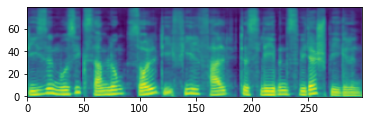

original audio


predicted audio


In [14]:
print("comparison 4")

audio, spectrogram = evaluate_spec_fastpitch_ckpt(cmp4_fp_model, cmp4_hfg_model, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

comparison 4 with emotion
torch.Size([1, 80, 648])


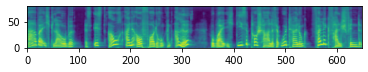

original audio


predicted audio for emotion 1:amused


torch.Size([1, 80, 692])


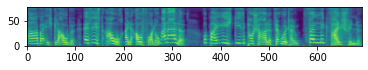

original audio


predicted audio for emotion 2:angry


torch.Size([1, 80, 722])


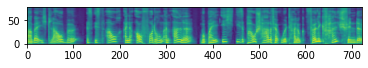

original audio


predicted audio for emotion 3:disgusted


torch.Size([1, 80, 830])


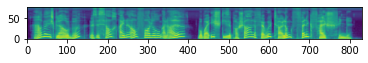

original audio


predicted audio for emotion 4:drunk


torch.Size([1, 80, 943])


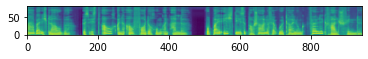

original audio


predicted audio for emotion 5:sleepy


torch.Size([1, 80, 572])


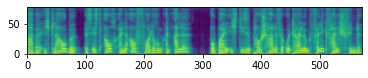

original audio


predicted audio for emotion 6:surprised


torch.Size([1, 80, 682])


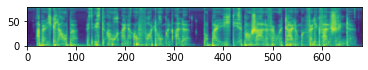

original audio


predicted audio for emotion 7:whisper


torch.Size([1, 80, 632])


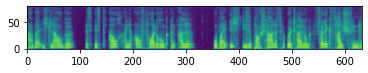

original audio


predicted audio for emotion 8:neutral


/opt/pytorch/pytorch/aten/src/ATen/native/cuda/Indexing.cu:665: indexSelectSmallIndex: block: [2,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/Indexing.cu:665: indexSelectSmallIndex: block: [2,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/Indexing.cu:665: indexSelectSmallIndex: block: [2,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/Indexing.cu:665: indexSelectSmallIndex: block: [2,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/Indexing.cu:665: indexSelectSmallIndex: block: [2,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/Indexing.cu:665: indexSelectSmallIndex: block: [2,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED
You can try to repro this exception using the following code snippet. If that doesn't trigger the error, please include your original repro script when reporting this issue.

import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
data = torch.randn([1, 1536, 1, 117], dtype=torch.float, device='cuda', requires_grad=True)
net = torch.nn.Conv2d(1536, 384, kernel_size=[1, 3], padding=[0, 1], stride=[1, 1], dilation=[1, 1], groups=1)
net = net.cuda().float()
out = net(data)
out.backward(torch.randn_like(out))
torch.cuda.synchronize()

ConvolutionParams 
    data_type = CUDNN_DATA_FLOAT
    padding = [0, 1, 0]
    stride = [1, 1, 0]
    dilation = [1, 1, 0]
    groups = 1
    deterministic = false
    allow_tf32 = true
input: TensorDescriptor 0x56098c24f1e0
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 1536, 1, 117, 
    strideA = 179712, 117, 117, 1, 
output: TensorDescriptor 0x560982ffff20
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 384, 1, 117, 
    strideA = 44928, 117, 117, 1, 
weight: FilterDescriptor 0x5609900ad340
    type = CUDNN_DATA_FLOAT
    tensor_format = CUDNN_TENSOR_NCHW
    nbDims = 4
    dimA = 384, 1536, 1, 3, 
Pointer addresses: 
    input: 0x7f46dd630000
    output: 0x7f46ddf9b600
    weight: 0x7f47886c0000
Forward algorithm: 1


In [15]:
print("comparison 4 with emotion")

for emotion in range(1,10):
    audio, spectrogram = evaluate_spec_fastpitch_ckpt(cmp4_fp_model, cmp4_hfg_model, test_emotion, emotion=emotion)

    # visualize the spectrogram
    if spectrogram is not None:
        imshow(spectrogram, origin="lower")
        plt.show()

    # audio
    print("original audio")
    ipd.display(ipd.Audio(data_path_emotions+emo_map[emotion]+"/"+test_id_emotion+'.wav', rate=22050))
    print("predicted audio for emotion "+str(emotion)+":"+emo_map[emotion])
    ipd.display(ipd.Audio(audio, rate=22050))

## 5. SHOULD WORK - `c1e1-FastPitch-finetune` + `c1e2-HifiGAN-finetune2-pretrain-emotional`

In [17]:
!ls /ngc_results_backup/emotionaltts/local-07282022_testc1e1_ngc_finetune/c1e1-FastPitch-finetune/2022-08-01_22-12-34/checkpoints/
!ls /ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/
# yet to work on c1e2-HifiGAN-finetune2-pretrain-emotional

'c1e1-FastPitch-finetune--v_loss=0.9004-epoch=24-last.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9004-epoch=24.ckpt'
 c1e1-FastPitch-finetune.nemo
'c1e1-FastPitch-finetune--v_loss=0.9089-epoch=124.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9119-epoch=199.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9128-epoch=149.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9167-epoch=174.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9181-epoch=274.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9224-epoch=299.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9225-epoch=249.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9229-epoch=324.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9275-epoch=99.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9324-epoch=224.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9793-epoch=1849-last.ckpt'
 c1e1-FastPitch-finetune.nemo


In [ ]:
cmp5_fp = "/ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo"
cmp5_hfg = 

In [ ]:
cmp5_fp_model = 
cmp5_hfg_model = 

## 6. NO USE - `c1e1-FastPitch-finetune` + `c1e2-HifiGAN-pretrain-emotional`

In [21]:
!ls /ngc_results_backup/emotionaltts/local-07282022_testc1e1_ngc_finetune/c1e1-FastPitch-finetune/2022-08-01_22-12-34/checkpoints/
!ls /ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/
!ls -alht /ngc_results_backup/emotionaltts/3251622-08162022_testc1e1_c1e2_ngc/c1e2-HifiGAN-pretrain-emotional/2022-08-17_04-19-27/checkpoints/

'c1e1-FastPitch-finetune--v_loss=0.9004-epoch=24-last.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9004-epoch=24.ckpt'
 c1e1-FastPitch-finetune.nemo
'c1e1-FastPitch-finetune--v_loss=0.9089-epoch=124.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9119-epoch=199.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9128-epoch=149.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9167-epoch=174.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9181-epoch=274.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9224-epoch=299.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9225-epoch=249.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9229-epoch=324.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9275-epoch=99.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9324-epoch=224.ckpt'
'c1e1-FastPitch-finetune--v_loss=0.9793-epoch=1849-last.ckpt'
 c1e1-FastPitch-finetune.nemo
total 4.0G
drwx------ 3 1001 1001 4.0K Aug 22 18:51  ..
-rw------- 1 1001 1001 970M Aug 22 18:51 'c1e1-HifiGAN-finetune-emotional--val_loss=0.3274-epoch=529.ckpt'
drwx------ 2 1001 1001 4.0K Aug 22 18:51 

In [22]:
cmp6_fp = "/ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/c1e1-FastPitch-finetune.nemo"
cmp6_hfg = "/ngc_results_backup/emotionaltts/3251622-08162022_testc1e1_c1e2_ngc/c1e2-HifiGAN-pretrain-emotional/2022-08-17_04-19-27/checkpoints/c1e1-HifiGAN-finetune-emotional--val_loss=0.3267-epoch=539.ckpt"

In [23]:
cmp6_fp_model = FastPitchModel.restore_from(restore_path=cmp6_fp).eval().cuda()
cmp6_hfg_model = HifiGanModel.load_from_checkpoint(checkpoint_path=cmp6_hfg).eval().cuda()

[NeMo I 2022-08-24 16:37:37 tokenize_and_classify:81] Creating ClassifyFst grammars. This might take some time...


[NeMo W 2022-08-24 16:38:02 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /DataEmotionalTTS/thorsten-emotional_v02/train_manifest_phonemes.json
      sample_rate: 22050
      sup_data_path: /DataEmotionalTTS/thorsten-emotional_v02/phonemes/
      sup_data_types:
      - align_prior_matrix
      - pitch
      - emotion_id
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004638671875
      pitch_norm: true
      pitch_mean: 169.59390258789062
      pitch_std: 103.64842224121094
      use_beta_binomial_interp

[NeMo I 2022-08-24 16:38:02 features:200] PADDING: 1


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
print("comparison 6")

audio, spectrogram = evaluate_spec_fastpitch_ckpt(cmp6_fp_model, cmp6_hfg_model, test, emotion=8)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

In [ ]:
print("comparison 6 with emotion")

for emotion in range(1,10):
    audio, spectrogram = evaluate_spec_fastpitch_ckpt(cmp6_fp_model, cmp6_hfg_model, test_emotion, emotion=emotion)

    # visualize the spectrogram
    if spectrogram is not None:
        imshow(spectrogram, origin="lower")
        plt.show()

    # audio
    print("original audio for emotion "+str(emotion))
    ipd.display(ipd.Audio(data_path_emotions+emo_map[emotion]+"/"+test_id_emotion+'.wav', rate=22050))
    print("predicted audio for emotion "+str(emotion)+":"+emo_map[emotion])
    ipd.display(ipd.Audio(audio, rate=22050))

## 7. IDEAL - `c1e1-FastPitch-finetune` + `c1e2-HifiGAN-finetune-emotional`

In [ ]:
!ls /ngc_results_backup/emotionaltts/local-07282022_testc1e1_ngc_finetune/c1e1-FastPitch-finetune/2022-08-01_22-12-34/checkpoints/
!ls /ngc_results_backup/emotionaltts/3244047-08142022_testc1e1_c1e2_ngc/c1e1-FastPitch-finetune/2022-08-15_22-07-51/checkpoints/
# yet to work on c1e2-HifiGAN-finetune-emotional

In [ ]:
# Thanks!